In [ ]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
import sklearn as sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
pip install keras_applications

     |████████████████████████████████| 50 kB 3.1 MB/s 


In [ ]:
dataset, info = tfds.load("cifar10", as_supervised=True, with_info=True)

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cifar10",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

50000

In [ ]:
class_names = info.features["label"].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

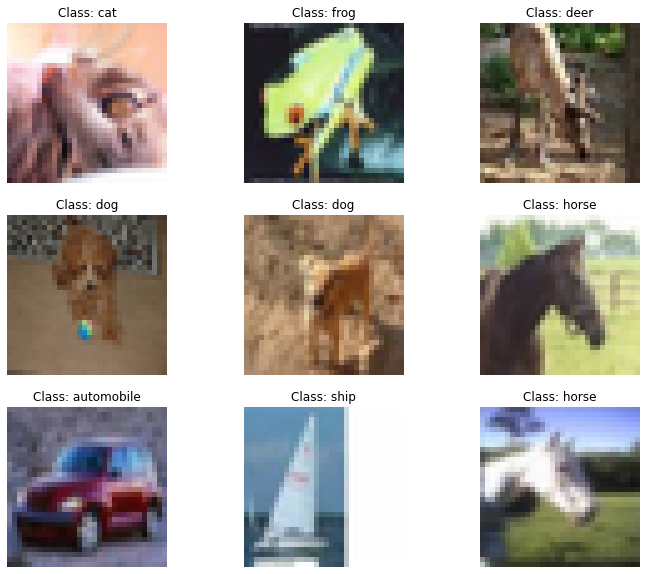

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
#Creating the base model of this CNN; this is the ResNet101 model wiith pretrained weights from the imagenet dataset
base_model = keras.applications.VGG16(include_top=False, weights="imagenet")

In [ ]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# history = model.fit(X_train, y_train,
#                     steps_per_epoch=int(0.75 * dataset_size / 32),
#                     validation_split=0.2,
#                     validation_steps=int(0.15 * dataset_size / 32),
#                     epochs=5)
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
1171/1171 [==============================] - 99s 81ms/step - loss: 2.6483 - accuracy: 0.4467 - val_loss: 1.2915 - val_accuracy: 0.5387
Epoch 2/5
1171/1171 [==============================] - 88s 75ms/step - loss: 1.2659 - accuracy: 0.5529 - val_loss: 1.1949 - val_accuracy: 0.5820
Epoch 3/5
1171/1171 [==============================] - 88s 76ms/step - loss: 1.2123 - accuracy: 0.5755 - val_loss: 1.1673 - val_accuracy: 0.5913
Epoch 4/5
1171/1171 [==============================] - 88s 75ms/step - loss: 1.1855 - accuracy: 0.5841 - val_loss: 1.1598 - val_accuracy: 0.5931
Epoch 5/5
1171/1171 [==============================] - 88s 75ms/step - loss: 1.1678 - accuracy: 0.5947 - val_loss: 1.1414 - val_accuracy: 0.6042


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=2, validation_split=0.2)

Epoch 1/15
875/875 - 18s - loss: nan - accuracy: 0.1014 - val_loss: nan - val_accuracy: 0.1001 - 18s/epoch - 21ms/step
Epoch 2/15
875/875 - 18s - loss: nan - accuracy: 0.1009 - val_loss: nan - val_accuracy: 0.1001 - 18s/epoch - 20ms/step
Epoch 3/15
875/875 - 17s - loss: nan - accuracy: 0.1009 - val_loss: nan - val_accuracy: 0.1001 - 17s/epoch - 19ms/step
Epoch 4/15
875/875 - 17s - loss: nan - accuracy: 0.1009 - val_loss: nan - val_accuracy: 0.1001 - 17s/epoch - 19ms/step
Epoch 5/15


KeyboardInterrupt: ignored